In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import shutil
import argparse
import time
import json
from datetime import datetime
from collections import defaultdict
from itertools import islice
import pickle
import copy
import numpy as np
import cv2
from easydict import EasyDict
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel
from tensorboardX import SummaryWriter

from mvn.models.triangulation import  VolumetricTriangulationNet
from mvn.models.volumetric_adain import VolumetricTemporalAdaINNet
from mvn.models.v2v import AdaIN, V2VModel, Basic3DBlock, Res3DBlock, Upsample3DBlock, Pool3DBlock, EncoderDecorder, C3D
from mvn.models import v2v
from mvn.models.temporal import get_normalization, Res1DBlock
from mvn.models.loss import KeypointsMSELoss, KeypointsMSESmoothLoss, KeypointsMAELoss, KeypointsL2Loss, VolumetricCELoss
from mvn.models import pose_hrnet, pose_resnet
from mvn.utils import img, multiview, op, vis, misc, cfg
from mvn.datasets.human36m import Human36MTemporalDataset, Human36MMultiViewDataset
from mvn.datasets import utils as dataset_utils

from mvn.utils.multiview import project_3d_points_to_image_plane_without_distortion
from mvn.utils.vis import draw_2d_pose
from mvn.utils import img
from mvn.utils import volumetric
from mvn.utils import op
from mvn.utils import vis
from mvn.utils import misc
from mvn.utils import cfg
from mvn.datasets import utils as dataset_utils
from mvn.utils.img import image_batch_to_numpy, denormalize_image,to_numpy

from tqdm import tqdm_notebook

from torch.nn.utils.rnn import pack_padded_sequence
from pytorch_convolutional_rnn.convolutional_rnn import Conv3dLSTM, Conv3dPeepholeLSTM, Conv2dLSTMCell, Conv2dPeepholeLSTM

CONNECTIVITY_DICT = {
    'cmu': [(0, 2), (0, 9), (1, 0), (1, 17), (2, 12), (3, 0), (4, 3), (5, 4), (6, 2), (7, 6), (8, 7), (9, 10), (10, 11), (12, 13), (13, 14), (15, 1), (16, 15), (17, 18)],
    'coco': [(0, 1), (0, 2), (1, 3), (2, 4), (5, 7), (7, 9), (6, 8), (8, 10), (11, 13), (13, 15), (12, 14), (14, 16), (5, 6), (5, 11), (6, 12), (11, 12)],
    "mpii": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 9), (8, 12), (8, 13), (10, 11), (11, 12), (13, 14), (14, 15)],
    "human36m": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 16), (9, 16), (8, 12), (11, 12), (10, 11), (8, 13), (13, 14), (14, 15)],
    "kth": [(0, 1), (1, 2), (5, 4), (4, 3), (6, 7), (7, 8), (11, 10), (10, 9), (2, 3), (3, 9), (2, 8), (9, 12), (8, 12), (12, 13)],
}

from train import setup_human36m_dataloaders

device = 'cuda:0'

def get_capacity(model):
    s_total = 0
    for param in model.parameters():
        s_total+=param.numel()
    return round(s_total / (10**6),2)

In [2]:
class FeatureDecoderLSTM(nn.Module):
    def __init__(self, style_vector_dim, feature_space, hidden_dim=512, time=5):
        super(FeatureDecoderLSTM, self).__init__()
        self.style_vector_dim = style_vector_dim
        self.feature_space = feature_space
        self.hidden_dim = hidden_dim
        
        self.style2cell_state = nn.Sequential(nn.ConvTranspose3d(style_vector_dim, hidden_dim//4,kernel_size=[1,2,2], stride=[1,2,2]),
                                             nn.LeakyReLU(), 
                                             nn.GroupNorm(32, hidden_dim//4),
                                             nn.ConvTranspose3d(hidden_dim//4,hidden_dim//2,kernel_size=[1,2,2], stride=[1,2,2]),
                                             nn.LeakyReLU(), 
                                             nn.GroupNorm(32, hidden_dim//2),
                                             nn.Conv3d(hidden_dim//2,hidden_dim,kernel_size=[time,1,1], stride=1),
                                             nn.LeakyReLU()
                                             )
        
        self.lstm_cell = Conv2dLSTMCell(in_channels=feature_space,
                                       out_channels=hidden_dim,
                                       kernel_size=feature_space,
                                       bias=True)
        
        self.hidden2feature = nn.Conv2d(hidden_dim, feature_space, kernel_size=1)

    def forward(self, style_vector, init_feature_map, time=5):
        
        hx_init = torch.zeros(1, self.hidden_dim, 96, 96).cuda()
        cx_init = self.style2cell_state(style_vector).squeeze(2)
        output = []
        for i in range(time):
            if i == 0:
                hx, cx = cell(init_feature_map, (hx_init, cx_init))
            else:
                hx, cx = cell(feature, (hx, cx))
                feature = self.hidden2feature(hx)
            output.append(feature)    
        
        output = torch.stack(output,1)
        return output
        

In [15]:
!nvidia-smi

Wed Apr  8 23:42:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.25                 Driver Version: 390.25                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
| 51%   57C    P8    18W / 280W |   2375MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:02:00.0 Off |                  N/A |
| 79%   79C    P2   154W / 280W |   9161MiB / 11178MiB |     91%      Default |
+-------------------------------+----------------------+----------------------+
        

In [7]:
model = FeatureDecoderLSTM(64,64, hidden_dim=64)#.cuda()
# model(s, torch.randn(1,256,96,96))

In [9]:
for m in model.parameters():
    print (m.shape)

torch.Size([64, 16, 1, 2, 2])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16, 32, 1, 2, 2])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 5, 1, 1])
torch.Size([64])
torch.Size([256, 64, 64, 64])
torch.Size([256, 64, 64, 64])
torch.Size([256])
torch.Size([256])
torch.Size([64, 64, 1, 1])
torch.Size([64])


In [8]:
get_capacity(model)

134.24

In [60]:
import torch
cell = Conv2dLSTMCell(in_channels=3, out_channels=5, kernel_size=3).cuda()
time = 6
input = torch.randn(time, 16, 3, 10, 10).cuda()
output = []
for i in range(time):
    if i == 0:
        hx, cx = cell(input[i])
    else:
        hx, cx = cell(input[i], (hx, cx))
    output.append(hx)

# All model sanity check

In [18]:
config_path = './experiments/human36m/train/human36m_vol_temporal_adain.yaml'

config = cfg.load_config(config_path)
config.dataset.val.retain_every_n_frames_in_test = 1

_, val_loader, _ = setup_human36m_dataloaders(config,
                                             is_train=False,
                                             distributed_train=False)

batch_size, dt, dilation = val_loader.batch_size, val_loader.dataset.dt, val_loader.dataset.dilation

pivot_type = config.dataset.pivot_type 
keypoints_per_frame = config.dataset.val.keypoints_per_frame if hasattr(config.dataset.val, 'keypoints_per_frame') else False
pivot_position = {'first':-1, 'intermediate':dt//2}[pivot_type]

if not hasattr(config.model.backbone, 'group_norm'):
    config.model.backbone.group_norm = False

print('Batch size:', batch_size, '\n',\
      'dt:', dt, '\n',\
      'dilation:', dilation, '\n',\
      'pivot_type:', pivot_type, '\n',\
      'pivot_position:', pivot_position,'\n',\
      'keypoints_per_frame', keypoints_per_frame)
    
model = {
    "vol": VolumetricTriangulationNet,
    "vol_temporal_adain":VolumetricTemporalAdaINNet
}[config.model.name](config, device=device).to(device)

print ('Loaded {} model'.format(config.model.name))

Batch size: 1 
 dt: 11 
 dilation: 3 
 pivot_type: intermediate 
 pivot_position: 5 
 keypoints_per_frame False
Loading pretrained weights from: ./data/pose_resnet_4.5_pixels_human36m.pth
Successfully loaded pretrained weights for backbone
Only resnet50 backbone is used...
backbone:  34.0M params
features_sequence_to_vector:  5.47M params
encoder:  0.0M params
volume_net:  57.39M params
process_features:  0.02M params
style_decoder:  2.11M params
Loaded vol_temporal_adain model


In [3]:
for batch in islice(50,val_loader, 3):

    n_views = batch['images'].shape[1]
    batch_size = batch['images'].shape[0]
    
    fig, axes = plt.subplots(ncols=n_views, nrows=1, figsize=(5 * n_views, 5))
    for i in range(n_views):
        # first row
        detection = batch['detections'][0][i]
        *bbox, c = detection
        
        image = batch['images'][0][i]
        image = denormalize_image(image).astype(np.uint8)
        image = image[..., ::-1]  # bgr -> rgb
        camera_name = batch['cameras'][i][0].name
        title = "{}, detection conf: {:.3}".format(camera_name, c)
        
        # second row
        keypoints_3d = batch['keypoints_3d'][0][:, :3]
        proj_matrix = batch['cameras'][i][0].projection
#         image_shape_before_resize = batch['image_shapes_before_resize'][0][i]
        image_shape = image.shape[:2]

        keypoints_2d_wrt_new = multiview.project_3d_points_to_image_plane_without_distortion(proj_matrix, keypoints_3d)
#         keypoints_2d_wrt_orig = transform_points_after_crop_and_resize(keypoints_2d_wrt_new, (bbox[0], bbox[1]), image_shape_before_resize, image_shape, forward=True)
        
        axes[i].set_xlim(0, image.shape[1])
        axes[i].set_ylim(0, image.shape[0])
        axes[i].invert_yaxis()
        axes[i].imshow(image)
        axes[i].scatter(keypoints_2d_wrt_new[:, 0], keypoints_2d_wrt_new[:, 1], s=10, c='red')
        
        axes[i].axis('off')
    plt.show()

ValueError: Indices for islice() must be None or an integer: 0 <= x <= sys.maxsize.

In [19]:
f = torch.randn(1,256,5,96,96).cuda()
s = model.features_sequence_to_vector(f)
s.shape

torch.Size([1, 64, 5, 24, 24])

In [51]:
keypoints = val_loader.dataset.labels['table'][200]['keypoints']
keypoints = keypoints[:,[1,2]]
connectivity = CONNECTIVITY_DICT['human36m']

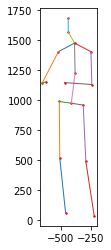

In [52]:
ax = plt.subplot(1,1,1)
# points
point_size=2
ax.scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=point_size)
line_width=1
radius=None
color=None

keypoints_mask = [True] * len(keypoints)
# connections
for (index_from, index_to) in connectivity:
    if keypoints_mask[index_from] and keypoints_mask[index_to]:
        xs, ys = [np.array([keypoints[index_from, j], keypoints[index_to, j]]) for j in range(2)]
        ax.plot(xs, ys, c=color, lw=line_width)

if radius is not None:
    root_keypoint_index = 0
    xroot, yroot = keypoints[root_keypoint_index, 0], keypoints[root_keypoint_index, 1]

    ax.set_xlim([-radius + xroot, radius + xroot])
    ax.set_ylim([-radius + yroot, radius + yroot])

ax.set_aspect('equal')


# Pretrained R(2+1)D

In [50]:
motion_extractor = VideoResNet(block=BasicBlock,
                                conv_makers=[Conv2Plus1D] * 4,
                                layers=[3, 4, 6, 3], # [3,4,6,3]
                                stem=R2Plus1dStem)
model.layer2[0].conv2[0] = Conv2Plus1D(128, 128, 288)
model.layer3[0].conv2[0] = Conv2Plus1D(256, 256, 576)
model.layer4[0].conv2[0] = Conv2Plus1D(512, 512, 1152)

x = torch.randn(3,3,8,112,112)
new_model = nn.Sequential(motion_extractor.stem, 
                          motion_extractor.layer1, 
                          motion_extractor.layer2,
                          motion_extractor.layer3)
new_model(x).shape

torch.Size([3, 256, 2, 14, 14])

In [58]:
n =nn.Sequential()
n.

In [52]:
get_capacity(new_model), get_capacity(model)

(23.97, 63.74)

In [10]:
from torchvision.models.video.resnet import VideoResNet, BasicBlock, R2Plus1dStem, Conv2Plus1D
weights_path = './data/r2plus1d_34_clip8_ig65m_from_scratch-9bae36ae.pth'

motion_extractor = VideoResNet(block=BasicBlock,
                                conv_makers=[Conv2Plus1D] * 4,
                                layers= [3,4,6,3], 
                                stem=R2Plus1dStem)
model.layer2[0].conv2[0] = Conv2Plus1D(128, 128, 288)
model.layer3[0].conv2[0] = Conv2Plus1D(256, 256, 576)
model.layer4[0].conv2[0] = Conv2Plus1D(512, 512, 1152)

weights_dict = torch.load(motion_extractor_path, map_location=device)
model_dict = motion_extractor.state_dict()
new_pretrained_state_dict = {}

for k, v in weights_dict.items():
    if k in model_dict:
        new_pretrained_state_dict[k] = weights_dict[k]
    else:    
        print (k, 'hasnt been loaded in C3D')

# We need exact Caffe2 momentum for BatchNorm scaling
if normalization_type == 'batch_norm':
    for m in model.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eps = 1e-3
            m.momentum = 0.9        
        
motion_extractor.load_state_dict(new_pretrained_state_dict)
get_capacity(motion_extractor)

In [11]:
get_capacity(motion_extractor)

63.74

# Pretrained V2V: C3D


In [2]:
features_sequence_to_vector = C3D(5,3)    

weights_dict = torch.load('./data/c3d.pickle', map_location=device)
model_dict = features_sequence_to_vector.state_dict()
new_pretrained_state_dict = {}

for k, v in weights_dict.items():
    if k in model_dict:
        new_pretrained_state_dict[k] = weights_dict[k]
    else:    
        print (k, 'hasnt been loaded in C3D')

features_sequence_to_vector.load_state_dict(new_pretrained_state_dict)
features_sequence_to_vector.to(device)
print (get_capacity(features_sequence_to_vector))

conv4a.weight hasnt been loaded in C3D
conv4a.bias hasnt been loaded in C3D
conv4b.weight hasnt been loaded in C3D
conv4b.bias hasnt been loaded in C3D
conv5a.weight hasnt been loaded in C3D
conv5a.bias hasnt been loaded in C3D
conv5b.weight hasnt been loaded in C3D
conv5b.bias hasnt been loaded in C3D
fc6.weight hasnt been loaded in C3D
fc6.bias hasnt been loaded in C3D
fc7.weight hasnt been loaded in C3D
fc7.bias hasnt been loaded in C3D
fc8.weight hasnt been loaded in C3D
fc8.bias hasnt been loaded in C3D
2.88


# TemporalDiscr


In [75]:
class TemporalDiscriminator(nn.Module):
    """docstring for TemporalDiscriminator"""
    def __init__(self, 
                 input_features_dim, 
                 output_features_dim=1024, 
                 intermediate_channels=512, 
                 normalization_type='group_norm',
                 dt = 8,
                 kernel_size = 3,
                 n_groups = 32):
        
        super().__init__()
        self.input_features_dim = input_features_dim
        self.output_features_dim = output_features_dim
        self.intermediate_channels = intermediate_channels
        self.normalization_type = normalization_type
        
        self.first_block = Res1DBlock(input_features_dim, 
                                      intermediate_channels,
                                      kernel_size=1,
                                      normalization_type=normalization_type)
        
        l = dt
        blocks =  []
        while l >= kernel_size:
            l = l - kernel_size + 1
            blocks.append(Res1DBlock(intermediate_channels, 
                                     intermediate_channels, 
                                     kernel_size=kernel_size,
                                     normalization_type=normalization_type))

            blocks.append(nn.Sequential(nn.Conv1d(intermediate_channels, intermediate_channels, kernel_size=3, padding=1),
                                        get_normalization(normalization_type, intermediate_channels, n_groups=n_groups, dimension=1),
                                        nn.ReLU(True),
                                        nn.Conv1d(intermediate_channels, intermediate_channels, kernel_size=3, padding=1),
                                        get_normalization(normalization_type, intermediate_channels, n_groups=n_groups, dimension=1),
                                        nn.ReLU(True)
                                        ))
        
        self.blocks = nn.Sequential(*blocks)    
        self.final_block = nn.Conv1d(intermediate_channels, 
                                      output_features_dim,
                                      kernel_size=l)
        
    def forward(self, x, device='cuda:0'):
        # [batch_size, dt, feature_shape]
        x = x.transpose(1,2) # [batch_size, dt, feature_shape] -> [batch_size, feature_shape, dt]
        x  = self.first_block(x)
        x  = self.blocks(x)
        x  = self.final_block(x)
        
        return x[...,0]

In [88]:
x = torch.randn(4,8,17,3)
[1,2,3,4][-2:]

[3, 4]